# Purpose
This notebook tests the naive training of the the completion network.

# Import

In [2]:
import torch
import torchvision

from glcic.networks.completion_network import CompletionNetwork
from glcic.trainers.cn_trainer import train_cn
from glcic.utils import *

# Train

In [3]:
# load the dataset
train_dataset_dir = '../data/train/'
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_dir, transform=torchvision.transforms.ToTensor())
train_dataloader = get_dataloader(train_dataset_dir, train_dataset_dir+"barn/00001008.jpg", batch_size=4)

In [4]:
# others
cn = CompletionNetwork().cuda()
optimizer = torch.optim.Adadelta(cn.parameters())
num_batch = 10
replacement_val = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])

In [5]:
# train
loss_list = train_cn(cn, optimizer, train_dataloader, num_batch, replacement_val, info=True)


### BATCH 1/10 ###
loss: 3773.704345703125

### BATCH 2/10 ###
loss: 3966.61474609375

### BATCH 3/10 ###
loss: 2146.61474609375

### BATCH 4/10 ###
loss: 2933.966796875

### BATCH 5/10 ###
loss: 2931.593994140625

### BATCH 6/10 ###
loss: 1735.119384765625

### BATCH 7/10 ###
loss: 3881.5244140625

### BATCH 8/10 ###
loss: 3622.703125

### BATCH 9/10 ###
loss: 2905.7373046875

### BATCH 10/10 ###
loss: 5005.681640625


In [6]:
# save checkpoint
resume_path = update_resume_path(train_dataset_dir, "../data/train/barn/00001032.jpg", num_batch, 4)
save_checkpoint("../logs/checkpoints/",
    cn,
    optimizer,
    [loss_list],
    num_batch,
    resume_path,
    replacement_val=replacement_val)

# Monitor the training

Total number of batch:  10
Path to resume training:  ../data/train/barn/00001072.jpg
Current replacement value:  tensor([0.5062, 0.4256, 0.3830])


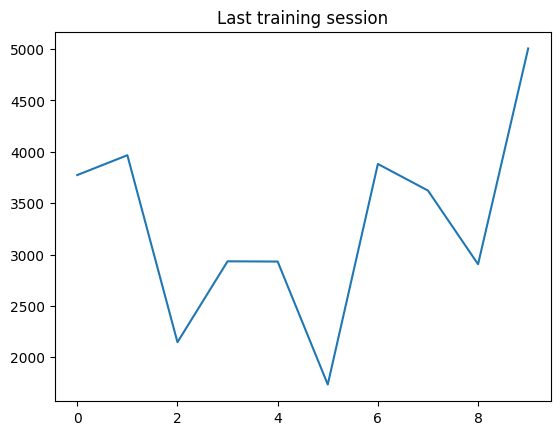

In [7]:
# last training session
loss_list, batch, resume_path, replacement_val = load_checkpoint(
        "../logs/checkpoints/", cn, optimizer
    )

import matplotlib.pyplot as plt
plt.plot(loss_list[-1])
plt.title("Last training session")

print("Total number of batch: ",batch)
print("Path to resume training: ",resume_path)
print("Current replacement value: ",replacement_val)

Text(0.5, 1.0, 'CN training\n Smoothed loss')

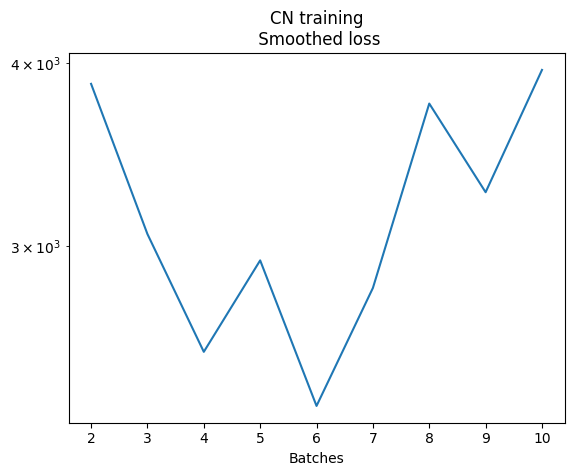

In [8]:
# full training
concatenated_loss_list = []
for loss in loss_list:
    concatenated_loss_list += loss
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

smooth_pts = 2 # 100
plt.semilogy(range(smooth_pts,len(concatenated_loss_list)+1),smooth(concatenated_loss_list,smooth_pts))
plt.xlabel("Batches")
plt.title("CN training\n Smoothed loss")

In [9]:
# estimated time
checkpoints_dir = "../logs/checkpoints/"
files = os.listdir("../logs/checkpoints/")

# sort by days
days = {}
for file in files:
    day = file[6:8]
    if day in days:
        days[day]+=[file]
    else:
        days[day]=[file]

# compute training time
total_training_time = 0
for checkpoints_list in days.values():
    ctimes = [os.path.getctime(checkpoints_dir+file) for file in checkpoints_list]
    total_training_time += max(ctimes)-min(ctimes)
print(f"Total training time is {int(total_training_time/3600)} hours")

Total training time is 0 hours


In [9]:
# estimated time left
checkpoints_dir = "../logs/checkpoints/"
files = os.listdir("../logs/checkpoints/")
file1 = checkpoints_dir+files[-2]
file2 = checkpoints_dir+files[-1]
checkpoint1 = torch.load(file1)
checkpoint2 = torch.load(file2)
batch1 =checkpoint1["batch"]
batch2 =checkpoint2["batch"]
time1 = os.path.getctime(file1)
time2 = os.path.getctime(file2)
average_batch_time = (time2-time1)/(batch2-batch1)
estimated_time = (90000-batch2)*average_batch_time

print(f"{estimated_time/3600} hours left")
print(f"{estimated_time/(24*3600)} days left")

ZeroDivisionError: float division by zero